In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# Global data
maxquant_file = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/combined/txt/evidence.txt' # path to MaxQuant results (evidence.txt) of the same RAW file, used for constructing reference dictionary
MS1Scans_NoArray = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/MS1Scans_NoArray.csv'
# experiment specific
#result_dir = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/msconvert_profile_ScanByScan_RTtol0.0_MZtol0.0005_condpeakRange_alpha10.0NoInterceptZz'
result_dir = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/msconvert_profile_ScanByScan_RTtol0.0_MZtol0.0005_condpeakRange_alpha0.0_abthres0.001_missabthres1.0_NoIntercept'
basename = os.path.basename(result_dir)
output_file = os.path.join(result_dir, basename + '_output') #filename

In [4]:
# Load maxquant result (reference)
Maxquant_result = pd.read_csv(filepath_or_buffer=maxquant_file, sep='\t')
activation = np.load(output_file+'_activationByScanFromLasso.npy')
emptyScans = pd.read_csv(filepath_or_buffer=output_file+'_EmptyScans.csv', index_col=0)
NonEmptyScans = pd.read_csv(filepath_or_buffer=output_file+'_NonEmptyScans.csv', index_col=0)
NonEmptyScans['FilteredPrecursor'] = NonEmptyScans['FilteredPrecursor'].str.split()
MS1Scans_NoArray = pd.read_csv(MS1Scans_NoArray)


In [5]:
# Make result directory
report_dir = os.path.join(result_dir, 'report')
if not os.path.exists(report_dir):
    os.makedirs(report_dir)
    os.makedirs(os.path.join(report_dir, 'activation'))

In [6]:
precursors = Maxquant_result.groupby(['Modified sequence', 'Leading proteins', 'Charge'])['Retention time'].count()

## Statistics

In [7]:
Maxquant_result.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'Experiment', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Resolution', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Match time difference',
       'Match m/z difference', 'Match q-value', 'Match score',
       'Number of data points', 'Number of scans', 'Number of isotopic peaks',
       'PIF', 'Fraction of total spectrum', 'Base 

In [10]:
import postprocessing.post_processing
from result_analysis.result_analysis import PlotCorr
reload(postprocessing.post_processing)
Maxquant_result['SumActivation'] = activation.sum(axis = 1)
#Maxquant_result_filtered = post_processing.TransformAndFilter(Maxquant_result=Maxquant_result)
RegIntensity, AbsResidue, valid_idx = PlotCorr(Maxquant_result['Intensity'], 
                                               Maxquant_result['SumActivation'],
                                               interactive=True, 
                                               data = Maxquant_result)
Maxquant_result_filtered = pd.DataFrame({'RegressionIntensity': RegIntensity, 'AbsResidue':AbsResidue})
Maxquant_result_filtered = pd.concat([Maxquant_result.loc[valid_idx[0], ['id', 'Sequence', 'Length', 'Modifications', 'Modified sequence','Intensity']], Maxquant_result_filtered], axis=1)
Maxquant_result_filtered['IntensityLog'] = np.log10(Maxquant_result_filtered['Intensity'])
Accurate50_idx = Maxquant_result_filtered['AbsResidue'].nsmallest(50).index
Inaccurate50_idx = Maxquant_result_filtered['AbsResidue'].nlargest(50).index

<module 'postprocessing.post_processing' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/post_processing.py'>

Data:  Intensity_log SumActivation_log , slope =  0.935 , intercept =  1.414 , PearsonR =  0.892 , SpearmanR =  0.878


ValueError: array length 17473 does not match index length 19430

## Recovered and MQ RT comparison

In [68]:
def FindStartAndEndScan(activation:np.ndarray,
                        thres:float = 1.0):
    """ 
    Given the activation matrix, finds the first and last value for each row (precursor) that is larger than given threshold 
    
    :actiavtion:
    :thres:
    """
    # Find the indices where the values are greater than 1
    row_indices, col_indices = np.where(activation >thres)  
    
    # Group col_indices by row_indices
    grouped_indices = pd.Series(col_indices).groupby(row_indices)

    # Calculate the minimum and maximum values for each group
    min_indices = grouped_indices.min()
    max_indices = grouped_indices.max()

    # Create a DataFrame to store the results
    df = pd.DataFrame({'id': min_indices.index, 'Start Scan': min_indices.values, 'End Scan': max_indices.values })
    df['CountScan'] = df['End Scan'] - df['Start Scan'] +1

    return df

In [69]:
ElutionScan = FindStartAndEndScan(activation=activation)
MS1Scans_NoArray['Scan Index'] = MS1Scans_NoArray.index
MQElutionScan = Maxquant_result[['id','Modified sequence', 'Charge', 'Retention length', 'Calibrated retention time start', 'Calibrated retention time finish',  'Number of data points', 'Number of scans', 'Number of isotopic peaks', 'Intensity']]
MQElutionScan.sort_values(by = 'Calibrated retention time start', inplace=True)
MQElutionScan= pd.merge_asof(left=MQElutionScan, right=MS1Scans_NoArray[['starttime', 'Scan Index']], left_on='Calibrated retention time start', right_on='starttime', direction='nearest')
MQElutionScan.sort_values(by = 'Calibrated retention time finish', inplace=True)
MQElutionScan= pd.merge_asof(left=MQElutionScan, right=MS1Scans_NoArray[['starttime', 'Scan Index']], left_on='Calibrated retention time finish', right_on='starttime', direction='nearest', suffixes=['_start', '_end'])
MQElutionScan['CountScan_MQ'] = MQElutionScan['Scan Index_end']-MQElutionScan['Scan Index_start']+1
ElutionScan = pd.merge(left=ElutionScan, right=MQElutionScan)
ElutionScan['MQ_SBS_diff'] = ElutionScan['CountScan_MQ']-ElutionScan['CountScan']

/tmp/ipykernel_29493/3254352687.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



count    17473.000000
mean         1.733875
std          1.064875
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         30.000000
Name: MQ_SBS_diff, dtype: float64

<Axes: >

Text(0.5, 0, 'Elution Scan Count MQ - Elution Scan Count SBS')

Text(0, 0.5, 'count')

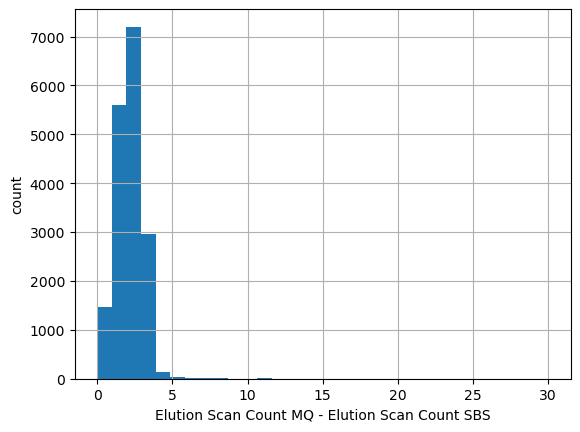

In [71]:
import matplotlib.pyplot as plt
ElutionScan = ElutionScan.dropna(subset=['Intensity'])
ElutionScan['MQ_SBS_diff'].describe()
ElutionScan['MQ_SBS_diff'].hist(bins=31)
plt.xlabel('Elution Scan Count MQ - Elution Scan Count SBS')
plt.ylabel('count')

## Batch smoothing

In [64]:
reload(postprocessing.post_processing)
try:
    refit_activation_minima = np.load(output_file+'_activationMinima.npy')
    sum_minima = pd.read_csv(os.path.join(result_dir, 'sum_minima.csv'))
except:
    refit_activation_minima, sum_minima = postprocessing.post_processing.SmoothActivationMatrix(activation=activation, MS1Scans_noArray=MS1Scans_NoArray, method='LocalMinima')
    np.save(output_file+'_activationMinima.npy', refit_activation_minima)
    sum_minima.to_csv(os.path.join(result_dir, 'sum_minima.csv'), index=False)
try:
    refit_activation_gaussian = np.load(output_file+'_activationGaussian.npy')
    sum_gaussian = pd.read_csv(os.path.join(result_dir, 'sum_gaussian.csv'))
except:
    refit_activation_gaussian, sum_gaussian = postprocessing.post_processing.SmoothActivationMatrix(activation=activation, MS1Scans_noArray=MS1Scans_NoArray, method='GaussianKernel')
    np.save(output_file+'_activationGaussian.npy', refit_activation_gaussian)
    sum_gaussian.to_csv(os.path.join(result_dir, 'sum_gaussian.csv'), index=False)

<module 'postprocessing.post_processing' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/post_processing.py'>

## Batch Correlation and Report

In [65]:
for sum_col in [sum_minima.iloc[:, 0], sum_minima.iloc[:, 1], sum_minima.iloc[:, 2], 
                sum_gaussian.iloc[:, 0], sum_gaussian.iloc[:, 1], sum_gaussian.iloc[:, 2], 
                Maxquant_result['SumActivation']]:
    _, _, _ = PlotCorr(Maxquant_result['Intensity'], sum_col, save_dir=report_dir)


Data:  SumActivationLocalMinima , slope =  0.917 , intercept =  1.568 , PearsonR =  0.881 , SpearmanR =  0.869
Data:  AUCAcitvationLocalMinima , slope =  0.909 , intercept =  0.023 , PearsonR =  0.882 , SpearmanR =  0.869
Data:  TRPZActivationLocalMinima , slope =  0.909 , intercept =  0.023 , PearsonR =  0.882 , SpearmanR =  0.869
Data:  SumActivationGaussianKernel , slope =  0.936 , intercept =  1.407 , PearsonR =  0.894 , SpearmanR =  0.88
Data:  AUCAcitvationGaussianKernel , slope =  0.927 , intercept =  -0.139 , PearsonR =  0.895 , SpearmanR =  0.88
Data:  TRPZActivationGaussianKernel , slope =  0.927 , intercept =  -0.139 , PearsonR =  0.895 , SpearmanR =  0.88
Data:  SumActivation , slope =  0.935 , intercept =  1.414 , PearsonR =  0.892 , SpearmanR =  0.878


In [66]:
from result_analysis.result_analysis import GenerateResultReport
NonEmptyScans = GenerateResultReport(emptyScans= emptyScans, 
                                     NonEmptyScans=NonEmptyScans,
                                     intensity_cols=[Maxquant_result['Intensity'],
                                                    Maxquant_result['SumActivation'], 
                                                    sum_gaussian.iloc[:, 0],
                                                    sum_gaussian.iloc[:, 1],
                                                    sum_minima.iloc[:, 0],
                                                    sum_minima.iloc[:, 1]
                                                    ],
                                     save_dir=report_dir)

-------------- Intensity -----------------
Non zero intensity in Intensity = 17477
-------------- SumActivation -----------------
Non zero intensity in SumActivation = 19415
-------------- SumActivationGaussianKernel -----------------
Non zero intensity in SumActivationGaussianKernel = 19415
-------------- AUCAcitvationGaussianKernel -----------------
Non zero intensity in AUCAcitvationGaussianKernel = 19415
-------------- SumActivationLocalMinima -----------------
Non zero intensity in SumActivationLocalMinima = 19415
-------------- AUCAcitvationLocalMinima -----------------
Non zero intensity in AUCAcitvationLocalMinima = 19415
--------------Empty Scans-----------------
Emptry Scans time distribution:
count    489.000000
mean       0.581534
std        0.345652
min        0.002775
25%        0.287077
50%        0.571042
75%        0.857887
max        1.240423
Name: Time, dtype: float64
--------------Non Empty Scans-----------------
Non Emptry Scans reconstruction cosine distance distr

### Plot Activation

In [67]:
from result_analysis.result_analysis import PlotActivation
for idx in Accurate50_idx:
    _ = PlotActivation(MaxquantEntry=Maxquant_result.iloc[idx, :], 
                                   PrecursorTimeProfiles=[activation[idx, :], refit_activation_minima[idx, :], refit_activation_gaussian[idx, :]],
                                   PrecursorTimeProfileLabels=['None', 'LocalMinima', 'Gaussian'],
                                   MS1ScansNoArrary=MS1Scans_NoArray, 
                                   save_dir=os.path.join(report_dir, 'activation', 'accurate'))
for idx in Inaccurate50_idx:
    _ = PlotActivation(MaxquantEntry=Maxquant_result.iloc[idx, :], 
                                   PrecursorTimeProfiles=[activation[idx, :], refit_activation_minima[idx, :], refit_activation_gaussian[idx, :]],
                                   PrecursorTimeProfileLabels=['None', 'LocalMinima', 'Gaussian'],
                                   MS1ScansNoArrary=MS1Scans_NoArray, 
                                   save_dir=os.path.join(report_dir, 'activation', 'inaccurate'))

### Precursor specific trouble shooting

In [6]:
# Load MS1 scans from pkl or mzml file
msconvert_file = '/mnt/cmnfs/proj/ORIGINs/protMSD/GCF_profile/msconvert_profile.mzML' # path to the data input in mzML format, containing only MS1 level data
with open(msconvert_file[:-5]+'.pkl', 'rb') as f:
    MS1Scans = pickle.load(f)

In [27]:
from optimization.dictionary import CalcModpeptIsopattern
Maxquant_result['IsoMZ'], Maxquant_result['IsoAbundance'] = zip(*Maxquant_result.apply(lambda row: CalcModpeptIsopattern(modpept=row['Modified sequence'], 
                                                                                                     charge=row['Charge'], ab_thres = 0.001), axis=1))


<module 'utility' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utility.py'>

Precursor  18083 eluted at  76.242 , corresponding scan index  3829 with scan time  76.2416156238556


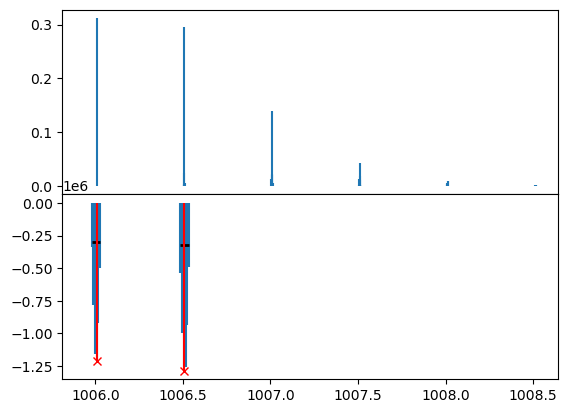

apex_mzidx      apex_mz  start_mzidx     start_mz  end_mzidx       end_mz  \
0           7  1006.007087            4  1005.978361          9  1006.026239   
1          20  1006.505206           18  1006.486040         23  1006.533955   

   peak_width   peak_height  peak_intensity_sum  
0    0.047878  302067.40625        4.906113e+06  
1    0.047914  321781.87500        5.505740e+06

In [28]:
from result_analysis.result_analysis import PlotIsoPatternAndScan
PlotIsoPatternAndScan(MS1Scans=MS1Scans, 
                              Maxquant_result=Maxquant_result, 
                              scan_idx = None, 
                              precursor_idx=18083, 
                              log_intensity=False)

<module 'utility' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utility.py'>

Cosine distance of non zero entries in prediction: 0.00980649186033511
Intensity Explained: 0.0434
Peaks Explained: 0.4591


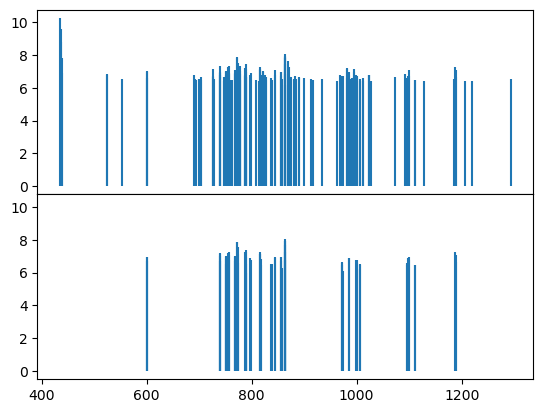

In [29]:
from optimization.dictionary import ConstructDict
from result_analysis.result_analysis import PlotTrueAndPredict
alignment = []
scan_idx = 3830
RT_tol = 1
alpha = 10
# example: generate dictionary for candidate in one scan
OneScan = MS1Scans.iloc[scan_idx, :]
CandidatePrecursorsByRT = Maxquant_result.loc[(Maxquant_result['Calibrated retention time start']-RT_tol <= OneScan['starttime']) & \
        (Maxquant_result['Calibrated retention time finish']+RT_tol>= OneScan['starttime'])]
if CandidatePrecursorsByRT.shape[0] > 0:
    CandidateDict, CandidatePrecursorsByRT, alignment, IsotopeNotObs, y_true, peak_results = ConstructDict(CandidatePrecursorsByRT, OneScan, method = 'peakRange')
    filteredPrecursorIdx = np.array(CandidateDict.columns[0:], dtype=int)
    if CandidateDict.shape[1] > 1:
        activationByScan, lossByScan, scoreByScan, pred, IntensityExplained, peaksExplained = utility.CalcPrecursorQuant(CandidateDict, y_true, filteredPrecursorIdx=filteredPrecursorIdx, alpha=alpha)
        activation[filteredPrecursorIdx, scan_idx] = activationByScan
        #non_empty_scans.append((scan_idx, OneScan['starttime'], lossByScan, scoreByScan, CandidatePrecursorsByRT.index, filteredPrecursorIdx))
        #ScanProcessRecords[scan_idx] = {'alignment':alignment}
        PlotTrueAndPredict(x = CandidateDict.index, prediction=pred, true=y_true['intensity'], log = True)
        print('Cosine distance of non zero entries in prediction:', scoreByScan)
        print('Intensity Explained:', np.round(IntensityExplained, 4))
        print('Peaks Explained:', np.round(peaksExplained, 4))
    else:
        print('Scan number, start time ', scan_idx, OneScan['starttime'], 'does not have valid candidate.')
        #empty_scans.append((scan_idx, OneScan['starttime'], 'No valid candidate after isotope pattern matching.'))

else:
        print('Scan number, start time ', scan_idx, OneScan['starttime'], 'does not have valid candidate.')
        #empty_scans.append((scan_idx, OneScan['starttime'], 'No valid candidate by RT'))


In [30]:
alignment[303]['abundance'].sum()
IsotopeNotObs[303]['abundance'].sum()

0.5232761444636144

0.4490588887347563

In [32]:
Maxquant_result.loc[11557, 'IsoAbundance'].sum()

0.9723350331983707

In [33]:
idx = np.where(filteredPrecursorIdx == 18082)
activationByScan[idx]

array([9769022.28253018])

In [17]:
import IsoSpecPy as iso
pair = [18083, 18082]
Maxquant_result.loc[pair, ['Modified sequence', 'Charge','Retention time', 'Intensity', 'm/z']]
iso.ParseFASTA(Maxquant_result.loc[pair[0], 'Modified sequence'])
iso.ParseFASTA(Maxquant_result.loc[pair[1], 'Modified sequence'])

Modified sequence  Charge  Retention time   Intensity  \
18083  _VNQIGTLTETFEAIEM(ox)AK_       2          76.242  27290000.0   
18082  _VNQIGTLTETFEAIEM(ox)AK_       2          75.905         NaN   

              m/z  
18083  1006.00626  
18082  1006.00626

OrderedDict([('C', 99), ('H', 162), ('N', 24), ('O', 32), ('S', 1)])

OrderedDict([('C', 99), ('H', 162), ('N', 24), ('O', 32), ('S', 1)])

In [122]:
import IsoSpecPy as iso
Maxquant_result.loc[[738, 10695], ['Modified sequence', 'Charge','Retention time', 'Intensity', 'm/z']]
iso.ParseFASTA(Maxquant_result.loc[738, 'Modified sequence'])
iso.ParseFASTA(Maxquant_result.loc[10695, 'Modified sequence'])

Modified sequence  Charge  Retention time   Intensity         m/z
738         _AISVDELQK_       2          21.921  26158000.0  501.776939
10695       _LGLENVETK_       2          21.921  26158000.0  501.776939

OrderedDict([('C', 43), ('H', 73), ('N', 11), ('O', 15), ('S', 0)])

OrderedDict([('C', 43), ('H', 73), ('N', 11), ('O', 15), ('S', 0)])

In [121]:
pair = [15879, 12747]
Maxquant_result.loc[pair, ['Modified sequence', 'Charge','Retention time', 'Intensity', 'm/z']]
iso.ParseFASTA(Maxquant_result.loc[pair[0], 'Modified sequence'])
iso.ParseFASTA(Maxquant_result.loc[pair[1], 'Modified sequence'])

Modified sequence  Charge  Retention time   Intensity         m/z
15879  _TDLINAVAEASSLSK_       2          70.373  20798000.0  759.904128
12747    _NIFSDPLTIEEIK_       2          70.373  20798000.0  759.906139

OrderedDict([('C', 64), ('H', 109), ('N', 17), ('O', 24), ('S', 0)])

OrderedDict([('C', 69), ('H', 109), ('N', 15), ('O', 22), ('S', 0)])

In [127]:
pair = [3772, 3774]
Maxquant_result.loc[pair, ['Modified sequence', 'Charge','Retention time', 'Intensity', 'm/z']]
iso.ParseFASTA(Maxquant_result.loc[pair[0], 'Modified sequence'])
iso.ParseFASTA(Maxquant_result.loc[pair[1], 'Modified sequence'])

Modified sequence  Charge  Retention time  Intensity         m/z
3772  _EHGAVFIIGIGDALR_       3          62.458  7362600.0  523.291219
3774  _EHGAVFIIGIGDALR_       3          62.330        NaN  523.291219

OrderedDict([('C', 71), ('H', 112), ('N', 20), ('O', 19), ('S', 0)])

OrderedDict([('C', 71), ('H', 112), ('N', 20), ('O', 19), ('S', 0)])

In [128]:
pair = [15120, 14965]
Maxquant_result.loc[pair, ['Modified sequence', 'Charge','Retention time', 'Intensity', 'm/z']]
iso.ParseFASTA(Maxquant_result.loc[pair[0], 'Modified sequence'])
iso.ParseFASTA(Maxquant_result.loc[pair[1], 'Modified sequence'])

Modified sequence  Charge  Retention time  Intensity         m/z
15120  _SLAEQNVILCFASGR_       2          62.377  8509700.0  832.924871
14965   _SIAAFAIHQFFQER_       2          62.060        NaN  832.930814

OrderedDict([('C', 69), ('H', 112), ('N', 20), ('O', 21), ('S', 1)])

OrderedDict([('C', 78), ('H', 111), ('N', 21), ('O', 19), ('S', 0)])

In [129]:
for idx in [738, 10695]+[15120, 14965]+[3772, 3774]+[15879, 12747]:
    _ = postprocessing.post_processing.PlotActivation(MaxquantEntry=Maxquant_result.iloc[idx, :], 
                                    PrecursorTimeProfiles=[activation[idx, :], refit_activation_minima[idx, :], refit_activation_gaussian[idx, :]],
                                    PrecursorTimeProfileLabels=['None', 'LocalMinima', 'Gaussian'],
                                    MS1ScansNoArrary=MS1Scans_NoArray, 
                                    save_dir=os.path.join(report_dir, 'activation', 'outliers'))